In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class PositionAttentionModule(nn.Module):
    ''' self-attention '''

    def __init__(self, in_channels):
        super().__init__()
        self.query_conv = nn.Conv1d(
            in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        inputs :
            x : feature maps from feature extractor. (N, C, H, W)
        outputs :
            feature maps weighted by attention along spatial dimensions
        """

        N, C, L = x.shape
        query = self.query_conv(x).view(
            N, -1, L).permute(0, 2, 1)  # (N, H*W, C')
        key = self.key_conv(x).view(N, -1, L)  # (N, C', H*W)

        # caluculate correlation
        energy = torch.bmm(query, key)    # (N, H*W, H*W)
        # spatial normalize
        attention = self.softmax(energy)

        value = self.value_conv(x).view(N, -1, L)    # (N, C, H*W)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(N, C, L)
        out = self.gamma*out + x
        return out

In [3]:
class ChannelAttentionModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        inputs :
            x : feature maps from feature extractor. (N, C, H, W)
        outputs :
            feature maps weighted by attention along a channel dimension
        """

        N, C, L = x.shape
        query = x.view(N, C, -1)    # (N, C, H*W)
        key = x.view(N, C, -1).permute(0, 2, 1)    # (N, H*W, C)

        # calculate correlation
        energy = torch.bmm(query, key)    # (N, C, C)
        energy = torch.max(
            energy, -1, keepdim=True)[0].expand_as(energy) - energy
        attention = self.softmax(energy)

        value = x.view(N, C, -1)

        out = torch.bmm(attention, value)
        out = out.view(N, C, L)
        out = self.gamma*out + x
        return out

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(x)
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell

In [5]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(hidden_size * 2, hidden_size, num_layers)
        self.conv1 = nn.Conv1d(20, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv1d(64, 20, kernel_size=3, stride=1, padding=1, bias=False)
        self.linear = nn.Linear(hidden_size * 3, hidden_size * 2)

        self.pam = PositionAttentionModule(in_channels=64)
        self.cam = ChannelAttentionModule()
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, encoder_states, hidden, cell):

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        attention_input = torch.cat((h_reshaped, encoder_states), dim=2)
        attention_input = attention_input.transpose(0,1)
        attention_input = self.conv1(attention_input)
        
        pam_out = self.pam(attention_input)
        cam_out = self.cam(attention_input)
        context_vector = pam_out + cam_out
        
        context_vector = self.conv2(context_vector)
        context_vector = self.linear(context_vector)
        context_vector = context_vector.transpose(0,1)

        rnn_input = context_vector
        # rnn_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell

In [6]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(20*22, 1)

    def forward(self, source, teacher_force_ratio=0.5):
        source = source.transpose(0,1)
        batch_size = source.shape[1]
        target_len = source.shape[0]
        target_vocab_size = 22

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden, cell = self.encoder(source)

        # At every time step use encoder_states and update hidden, cell
        output, hidden, cell = self.decoder(encoder_states, hidden, cell)

        # Store prediction for current time step
        outputs = output
            
        outputs = outputs.transpose(0,1)
        outputs = self.flatten(outputs)
        outputs = self.final_layer(outputs)

        return outputs

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_net = Encoder(
    input_size=22,  
    hidden_size=32, 
    num_layers=1, 
    p=0
).to(device)

decoder_net = Decoder(
    input_size=22,
    hidden_size=32,
    output_size=22,
    num_layers=1,
    p=0,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [8]:
x = torch.randn(5, 20, 22).to(device=device)
y = model(x,x)
print(y.shape)
print(y)

torch.Size([5, 1])
tensor([[-0.1244],
        [-0.1237],
        [-0.1238],
        [-0.1220],
        [-0.1136]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [10]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [11]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [12]:
df_for_training=df[feature_names].astype(float)

In [13]:
df_for_training.shape

(11524, 22)

In [14]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [15]:
trainX=[]
trainY=[]

In [16]:
n_future=1
n_past=20

In [17]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [18]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [19]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [20]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [21]:
data,label=random_shuffle(trainX,trainY)

In [22]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [24]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #output = model(data1, data2)
        output = model(data)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.11321662366390228
Epoch: 1 Loss: 0.21487852931022644
Epoch: 2 Loss: 0.03403245657682419
Epoch: 3 Loss: 0.04761017486453056
Epoch: 4 Loss: 0.018357926979660988
Epoch: 5 Loss: 0.14897218346595764
Epoch: 6 Loss: 0.07323601096868515
Epoch: 7 Loss: 0.12336321175098419
Epoch: 8 Loss: 0.17367681860923767
Epoch: 9 Loss: 0.0263151153922081
Epoch: 10 Loss: 0.015115533024072647
Epoch: 11 Loss: 0.15276670455932617
Epoch: 12 Loss: 0.16295510530471802
Epoch: 13 Loss: 0.037650175392627716
Epoch: 14 Loss: 0.018476177006959915
Epoch: 15 Loss: 0.041367389261722565
Epoch: 16 Loss: 0.05021274462342262
Epoch: 17 Loss: 0.03621632605791092
Epoch: 18 Loss: 0.04396122694015503
Epoch: 19 Loss: 0.09305751323699951
Epoch: 20 Loss: 0.02035481669008732
Epoch: 21 Loss: 0.01577521115541458
Epoch: 22 Loss: 0.013124525547027588
Epoch: 23 Loss: 0.026811452582478523
Epoch: 24 Loss: 0.008332928642630577
Epoch: 25 Loss: 0.054551899433135986
Epoch: 26 Loss: 0.03617057204246521
Epoch: 27 Loss: 0.035577356815

Epoch: 221 Loss: 0.02368369698524475
Epoch: 222 Loss: 0.008085665293037891
Epoch: 223 Loss: 0.004902251064777374
Epoch: 224 Loss: 0.00840054452419281
Epoch: 225 Loss: 0.009773094207048416
Epoch: 226 Loss: 0.028506048023700714
Epoch: 227 Loss: 0.004220207687467337
Epoch: 228 Loss: 0.007868853397667408
Epoch: 229 Loss: 0.014886077493429184
Epoch: 230 Loss: 0.010556254535913467
Epoch: 231 Loss: 0.01963673159480095
Epoch: 232 Loss: 0.02409961447119713
Epoch: 233 Loss: 0.0031348327174782753
Epoch: 234 Loss: 0.014543112367391586
Epoch: 235 Loss: 0.009556012228131294
Epoch: 236 Loss: 0.006580494809895754
Epoch: 237 Loss: 0.011172592639923096
Epoch: 238 Loss: 0.024491693824529648
Epoch: 239 Loss: 0.015491928905248642
Epoch: 240 Loss: 0.004112329334020615
Epoch: 241 Loss: 0.018885256722569466
Epoch: 242 Loss: 0.02369518391788006
Epoch: 243 Loss: 0.009998045861721039
Epoch: 244 Loss: 0.010210545733571053
Epoch: 245 Loss: 0.005295411217957735
Epoch: 246 Loss: 0.006731599569320679
Epoch: 247 Loss:

Epoch: 438 Loss: 0.008680209517478943
Epoch: 439 Loss: 0.011910935863852501
Epoch: 440 Loss: 0.0049533480778336525
Epoch: 441 Loss: 0.015465300530195236
Epoch: 442 Loss: 0.012911975383758545
Epoch: 443 Loss: 0.009930631145834923
Epoch: 444 Loss: 0.007333796471357346
Epoch: 445 Loss: 0.0061384811997413635
Epoch: 446 Loss: 0.0058164047077298164
Epoch: 447 Loss: 0.010242832824587822
Epoch: 448 Loss: 0.013391923159360886
Epoch: 449 Loss: 0.009207134135067463
Epoch: 450 Loss: 0.017222369089722633
Epoch: 451 Loss: 0.01532089151442051
Epoch: 452 Loss: 0.016753025352954865
Epoch: 453 Loss: 0.04855216294527054
Epoch: 454 Loss: 0.018438519909977913
Epoch: 455 Loss: 0.004328220151364803
Epoch: 456 Loss: 0.013274084776639938
Epoch: 457 Loss: 0.01219865120947361
Epoch: 458 Loss: 0.008614985272288322
Epoch: 459 Loss: 0.009233145043253899
Epoch: 460 Loss: 0.013245344161987305
Epoch: 461 Loss: 0.005786593072116375
Epoch: 462 Loss: 0.006333057768642902
Epoch: 463 Loss: 0.00453077582642436
Epoch: 464 Lo

Epoch: 655 Loss: 0.013951491564512253
Epoch: 656 Loss: 0.005496669560670853
Epoch: 657 Loss: 0.013506249524652958
Epoch: 658 Loss: 0.006061563268303871
Epoch: 659 Loss: 0.014262929558753967
Epoch: 660 Loss: 0.010600382462143898
Epoch: 661 Loss: 0.006502438336610794
Epoch: 662 Loss: 0.025423860177397728
Epoch: 663 Loss: 0.006391381844878197
Epoch: 664 Loss: 0.0062961820513010025
Epoch: 665 Loss: 0.007608017884194851
Epoch: 666 Loss: 0.00996197760105133
Epoch: 667 Loss: 0.0028074239380657673
Epoch: 668 Loss: 0.0070312293246388435
Epoch: 669 Loss: 0.004888581112027168
Epoch: 670 Loss: 0.0050403522327542305
Epoch: 671 Loss: 0.004291769117116928
Epoch: 672 Loss: 0.010188844986259937
Epoch: 673 Loss: 0.003576480783522129
Epoch: 674 Loss: 0.009779022075235844
Epoch: 675 Loss: 0.014770728535950184
Epoch: 676 Loss: 0.010255584493279457
Epoch: 677 Loss: 0.005122646689414978
Epoch: 678 Loss: 0.016833124682307243
Epoch: 679 Loss: 0.011155735701322556
Epoch: 680 Loss: 0.011586736887693405
Epoch: 68

Epoch: 871 Loss: 0.008154429495334625
Epoch: 872 Loss: 0.014370886608958244
Epoch: 873 Loss: 0.014765484258532524
Epoch: 874 Loss: 0.019707735627889633
Epoch: 875 Loss: 0.011087507009506226
Epoch: 876 Loss: 0.0028084064833819866
Epoch: 877 Loss: 0.009326744824647903
Epoch: 878 Loss: 0.014192361384630203
Epoch: 879 Loss: 0.005921746604144573
Epoch: 880 Loss: 0.01314927265048027
Epoch: 881 Loss: 0.013907242566347122
Epoch: 882 Loss: 0.004327412229031324
Epoch: 883 Loss: 0.0033186255022883415
Epoch: 884 Loss: 0.010724925436079502
Epoch: 885 Loss: 0.020708555355668068
Epoch: 886 Loss: 0.011666403152048588
Epoch: 887 Loss: 0.008098393678665161
Epoch: 888 Loss: 0.013670873828232288
Epoch: 889 Loss: 0.004952838644385338
Epoch: 890 Loss: 0.008737219497561455
Epoch: 891 Loss: 0.006649572402238846
Epoch: 892 Loss: 0.004001806490123272
Epoch: 893 Loss: 0.022273097187280655
Epoch: 894 Loss: 0.014267807826399803
Epoch: 895 Loss: 0.008309699594974518
Epoch: 896 Loss: 0.004789150319993496
Epoch: 897 

In [25]:
test_data = torch.from_numpy(trainX_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    data = data.to(device=device)
    output = model(data)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [27]:
predictions = np.array(predictions)

In [28]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [29]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

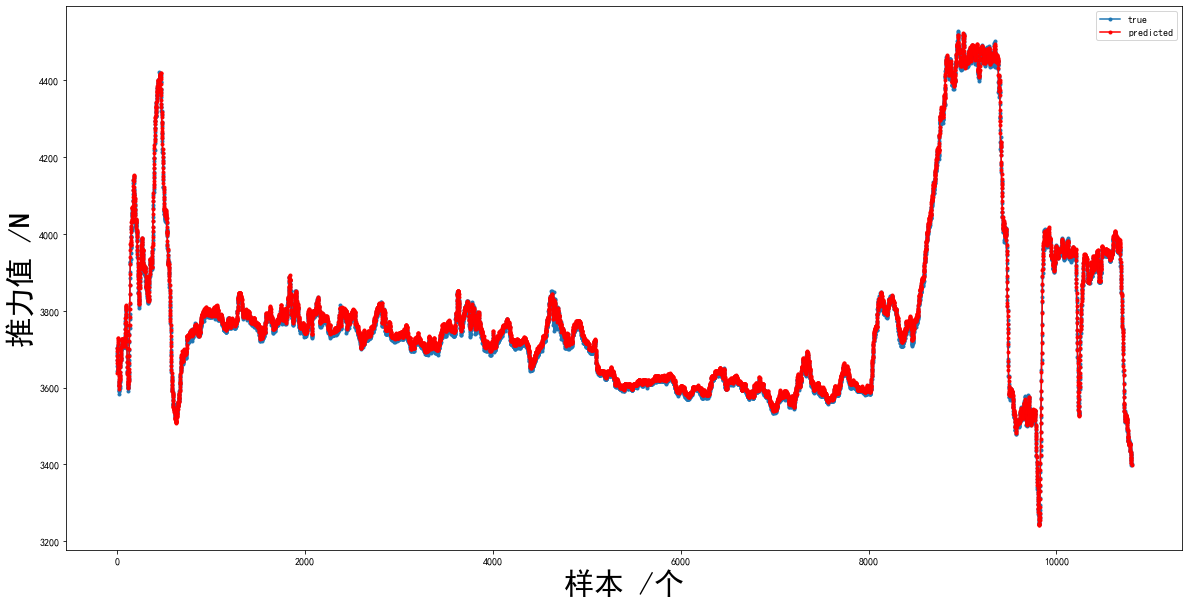

In [30]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();